In [1]:

import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!pip install pyspark
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"


# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import findspark and initialize.
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql.types import IntegerType, DoubleType



Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 110 kB in 1s (76.8 kB/s)
Reading package lists... Done


In [2]:
#initialize.
findspark.init()
# Start Spark session
spark = SparkSession.builder.appName("Dementia").getOrCreate()

In [3]:
# Read in data

url = r'https://dementia-data-2024-project-4.s3.us-west-2.amazonaws.com/dementia_patients_health_data.csv'
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("dementia_patients_health_data.csv"), sep=",", header=True)


# Show DataFrame
df.show()

+--------+------------------+---------+-----------------+-----------------+------------------+------------------+------------+------------+---+----------------+-------------+------+--------------+--------------+--------+-----------------+-----------------+---------------------+------------------+------------------+-------------+-------------------------+--------+
|Diabetic|      AlcoholLevel|HeartRate| BloodOxygenLevel|  BodyTemperature|            Weight|         MRI_Delay|Prescription|Dosage in mg|Age| Education_Level|Dominant_Hand|Gender|Family_History|Smoking_Status| APOE_ε4|Physical_Activity|Depression_Status|Cognitive_Test_Scores|Medication_History|    Nutrition_Diet|Sleep_Quality|Chronic_Health_Conditions|Dementia|
+--------+------------------+---------+-----------------+-----------------+------------------+------------------+------------+------------+---+----------------+-------------+------+--------------+--------------+--------+-----------------+-----------------+------------

In [4]:
df.printSchema()

root
 |-- Diabetic: string (nullable = true)
 |-- AlcoholLevel: string (nullable = true)
 |-- HeartRate: string (nullable = true)
 |-- BloodOxygenLevel: string (nullable = true)
 |-- BodyTemperature: string (nullable = true)
 |-- Weight: string (nullable = true)
 |-- MRI_Delay: string (nullable = true)
 |-- Prescription: string (nullable = true)
 |-- Dosage in mg: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Dominant_Hand: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Family_History: string (nullable = true)
 |-- Smoking_Status: string (nullable = true)
 |-- APOE_ε4: string (nullable = true)
 |-- Physical_Activity: string (nullable = true)
 |-- Depression_Status: string (nullable = true)
 |-- Cognitive_Test_Scores: string (nullable = true)
 |-- Medication_History: string (nullable = true)
 |-- Nutrition_Diet: string (nullable = true)
 |-- Sleep_Quality: string (nullable = true)
 |-- Chronic_Health_

In [5]:
#convert the data types

df = df.withColumn("AlcoholLevel", df["AlcoholLevel"].cast(DoubleType()))
df = df.withColumn("HeartRate", df["HeartRate"].cast(IntegerType()))
df = df.withColumn("BloodOxygenLevel", df["BloodOxygenLevel"].cast(DoubleType()))
df = df.withColumn("BodyTemperature", df["BodyTemperature"].cast(DoubleType()))
df = df.withColumn("Weight", df["Weight"].cast(DoubleType()))
df = df.withColumn("MRI_Delay", df["MRI_Delay"].cast(DoubleType()))
df = df.withColumn("Age", df["Age"].cast(IntegerType()))
df = df.withColumn("Cognitive_Test_Scores", df["Cognitive_Test_Scores"].cast(IntegerType()))
df = df.withColumn("Dementia", df["Dementia"].cast(IntegerType()))


In [6]:
df.summary().show()

+-------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------+-----------------+-----------------+----------------+-------------+------+--------------+--------------+--------+-----------------+-----------------+---------------------+------------------+------------------+-------------+-------------------------+------------------+
|summary|          Diabetic|       AlcoholLevel|         HeartRate| BloodOxygenLevel|   BodyTemperature|            Weight|         MRI_Delay|Prescription|     Dosage in mg|              Age| Education_Level|Dominant_Hand|Gender|Family_History|Smoking_Status| APOE_ε4|Physical_Activity|Depression_Status|Cognitive_Test_Scores|Medication_History|    Nutrition_Diet|Sleep_Quality|Chronic_Health_Conditions|          Dementia|
+-------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+----------

In [7]:
df = df.withColumnRenamed('APOE_ε4', 'APOE')

In [8]:
# Create TempView
df.createOrReplaceTempView("dementia_data")

In [9]:
# factors by dementia status
query = """
    SELECT
        AVG(HeartRate) AS avg_heart_rate,
        AVG(BloodOxygenLevel) AS avg_blood_oxygen,
        AVG(BodyTemperature) AS avg_body_temperature,
        AVG(Weight) AS avg_weight,
        AVG(Age) AS avg_age,
        Dementia
    FROM dementia_data
    GROUP BY Dementia
"""

result = spark.sql(query)
result.show()



+-----------------+-----------------+--------------------+-----------------+-----------------+--------+
|   avg_heart_rate| avg_blood_oxygen|avg_body_temperature|       avg_weight|          avg_age|Dementia|
+-----------------+-----------------+--------------------+-----------------+-----------------+--------+
| 79.5360824742268|95.01047449783889|   36.77659805923553|73.58299101270836| 74.3257731958763|       1|
|79.23883495145631|95.42906965312902|   36.74730630525481|75.01665133053221|75.45631067961165|       0|
+-----------------+-----------------+--------------------+-----------------+-----------------+--------+



In [10]:
#convert to pandas dataframe
averages_dementia = result.toPandas()
averages_dementia


,avg_heart_rate,avg_blood_oxygen,avg_body_temperature,avg_weight,avg_age,Dementia
0,79.536082,95.010474,36.776598,73.582991,74.325773,1
1,79.238835,95.429070,36.747306,75.016651,75.456311,0


In [11]:
#melt results to create grouped bar plot
result_melted = pd.melt(averages_dementia, id_vars='Dementia', var_name='Factor', value_name='Average Value')


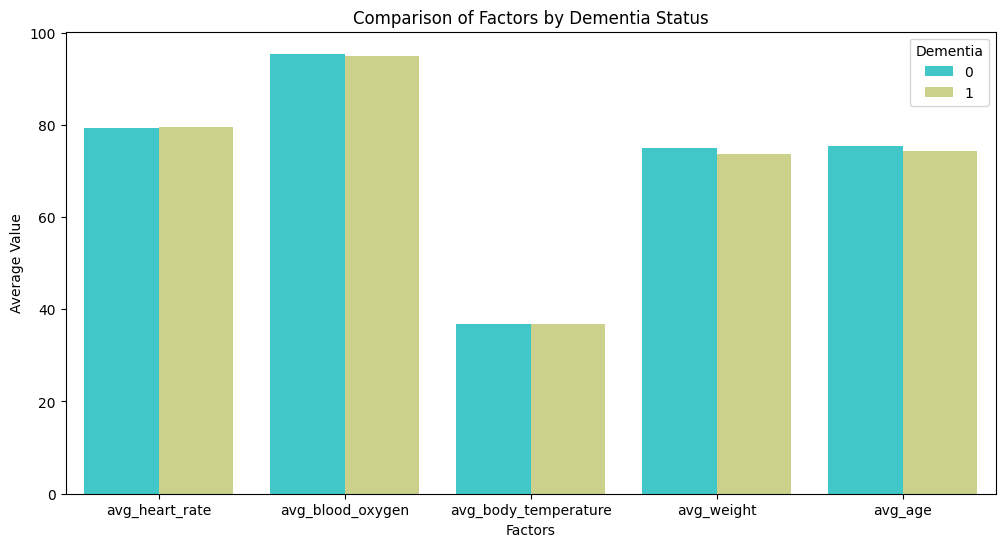

In [12]:
#dementia status by multiple factors
plt.figure(figsize=(12, 6))
sns.barplot(x='Factor', y='Average Value', hue='Dementia', data=result_melted, palette='rainbow')
plt.title('Comparison of Factors by Dementia Status')
plt.xlabel('Factors')
plt.ylabel('Average Value')
plt.show()

In [13]:
plt.show()

In [14]:
# dementia status by sleep quality
query = """
    SELECT
        Sleep_Quality,
        COUNT(*) AS Dementia_Count
    FROM dementia_data
    WHERE Dementia = 1 AND Sleep_Quality IN ('Poor', 'Good')
    GROUP BY Sleep_Quality
"""
sleep_result = spark.sql(query)
sleep_result_df = sleep_result.toPandas()
sleep_result_df

,Sleep_Quality,Dementia_Count
0,Good,221
1,Poor,264


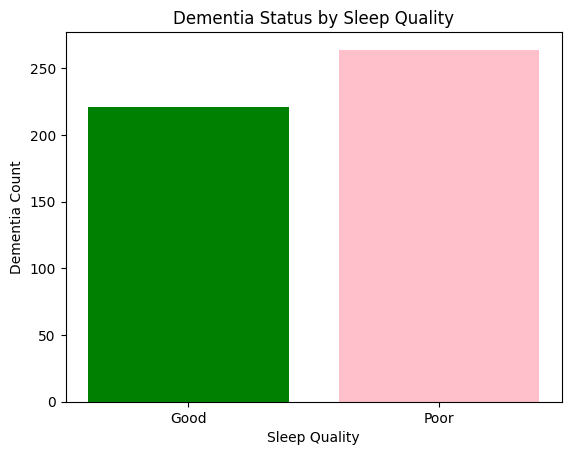

In [15]:
#plot for dementia status by sleep quality
plt.bar(sleep_result_df['Sleep_Quality'], sleep_result_df['Dementia_Count'], color=['green', 'pink'])
plt.xlabel('Sleep Quality')
plt.ylabel('Dementia Count')
plt.title('Dementia Status by Sleep Quality')
plt.show()

In [16]:
#dementia status by chronic health conditions
query = """
    SELECT
        Chronic_Health_Conditions,
        COUNT(*) AS Dementia_Count
    FROM dementia_data
    WHERE Dementia = 1
    GROUP BY Chronic_Health_Conditions
"""

chronic_health_result = spark.sql(query)
chronic_health_result_df = chronic_health_result.toPandas()
chronic_health_result_df

,Chronic_Health_Conditions,Dementia_Count
0,None,88
1,Heart Disease,65
2,Diabetes,260
3,Hypertension,72


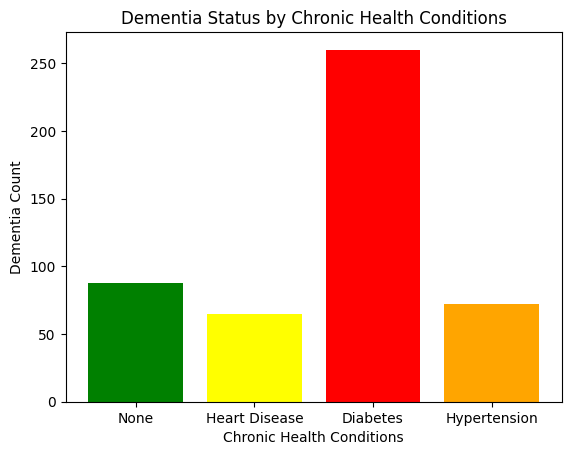

In [17]:
# plot for dementia status by chronic health conditions
plt.bar(chronic_health_result_df['Chronic_Health_Conditions'], chronic_health_result_df['Dementia_Count'], color=['green', 'yellow', 'red', 'orange'])
plt.xlabel('Chronic Health Conditions')
plt.ylabel('Dementia Count')
plt.title('Dementia Status by Chronic Health Conditions')
plt.show()

In [18]:
# dementia status by family history
query = """
    SELECT
        Family_History,
        COUNT(*) AS Dementia_Count
    FROM dementia_data
    WHERE Dementia = 1
    GROUP BY Family_History
"""


family_history_result = spark.sql(query)
family_history_result_df = family_history_result.toPandas()
family_history_result_df


,Family_History,Dementia_Count
0,No,255
1,Yes,230


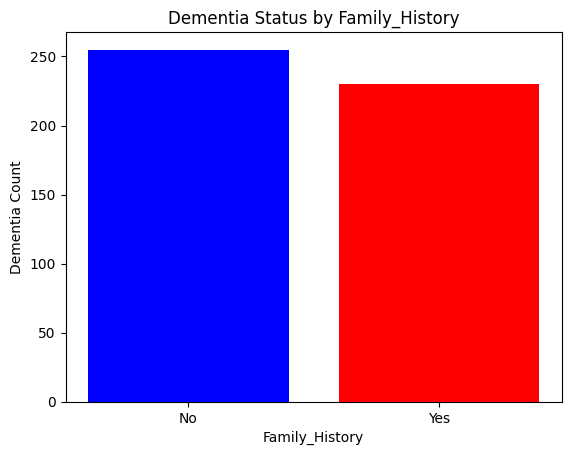

In [19]:
#plot for dementia status by family history
plt.bar(family_history_result_df['Family_History'], family_history_result_df['Dementia_Count'], color=['blue', 'red'])
plt.xlabel('Family_History')
plt.ylabel('Dementia Count')
plt.title('Dementia Status by Family_History')
plt.show()

In [20]:
# dementia count by cognitive test score
query = """
    SELECT
        Cognitive_Test_Scores,
        COUNT(*) AS Dementia_Count
    FROM dementia_data
    WHERE Dementia = 1
    GROUP BY Cognitive_Test_Scores
    ORDER BY Cognitive_Test_Scores DESC
"""

cog_test_scores_result = spark.sql(query)
cog_test_scores_result_df = cog_test_scores_result.toPandas()
cog_test_scores_result_df

,Cognitive_Test_Scores,Dementia_Count
0,7,65
1,6,60
2,5,78
3,4,55
4,3,54
5,2,56
6,1,57
7,0,60


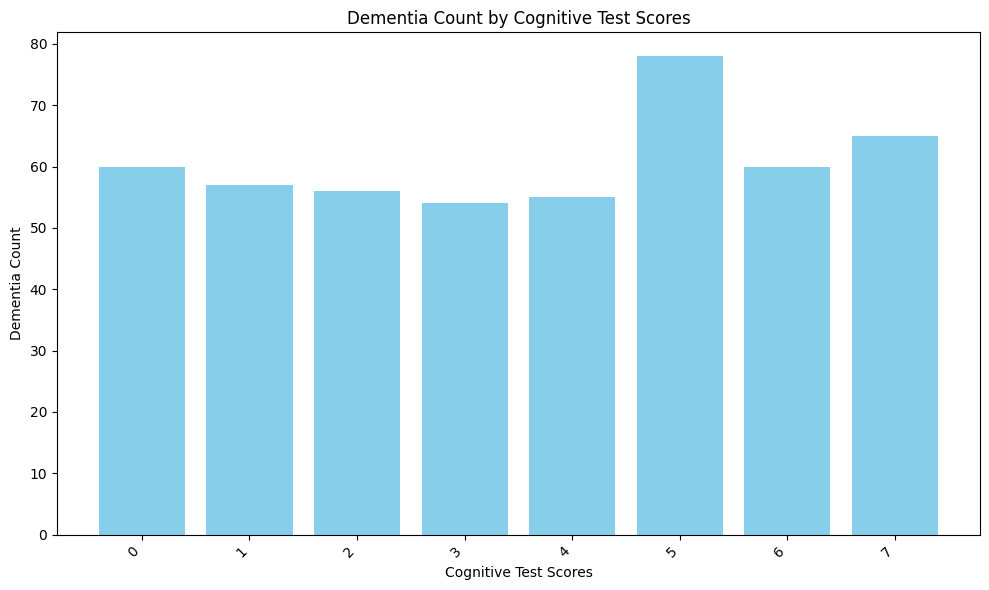

In [21]:
#plot for dementia count by cognitive test score
plt.figure(figsize=(10, 6))
plt.bar(cog_test_scores_result_df['Cognitive_Test_Scores'], cog_test_scores_result_df['Dementia_Count'], color='skyblue')
plt.xlabel('Cognitive Test Scores')
plt.ylabel('Dementia Count')
plt.title('Dementia Count by Cognitive Test Scores')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [22]:
query = """
    SELECT
    *
    FROM dementia_data

"""

dementia = spark.sql(query)
dementia_df = dementia.toPandas()
dementia_df

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,...,Smoking_Status,APOE,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,None,None,60,...,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,Galantamine,12.0,61,...,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,None,None,69,...,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,Donepezil,23.0,78,...,Never Smoked,Negative,Mild Activity,Yes,5,Yes,Balanced Diet,Poor,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,Memantine,20.0,77,...,Never Smoked,Positive,Mild Activity,No,0,Yes,Low-Carb Diet,Good,Diabetes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0.081825,87,93.851963,36.495134,50.380106,42.318663,Donepezil,10.0,88,...,Never Smoked,Positive,Mild Activity,No,5,No,Balanced Diet,Poor,Diabetes,1
996,1,0.145249,97,94.522391,36.270804,94.006484,52.812568,None,None,80,...,Never Smoked,Negative,Moderate Activity,No,9,Yes,Low-Carb Diet,Poor,Diabetes,0
997,1,0.073692,65,98.578388,37.065703,80.088613,13.640229,None,None,67,...,Never Smoked,Positive,Sedentary,No,8,Yes,Balanced Diet,Good,Diabetes,0
998,0,0.037347,71,91.298580,37.037202,95.322210,17.445715,Memantine,20.0,62,...,Never Smoked,Positive,Sedentary,Yes,2,No,Low-Carb Diet,Good,None,1


In [23]:
dementia_df.describe()

,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Cognitive_Test_Scores,Dementia
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.098429,79.383000,95.226051,36.761513,74.321326,30.103568,74.908000,6.383000,0.485000
std,0.058715,12.107556,2.929262,0.431701,14.463765,16.862170,9.095068,3.180633,0.500025
min,0.000414,60.000000,90.010677,36.002108,50.069731,0.094684,60.000000,0.000000,0.000000
25%,0.045505,68.000000,92.875017,36.395363,61.387339,16.237371,67.000000,4.000000,0.000000
50%,0.098235,79.000000,95.390420,36.784319,74.149204,29.577194,75.000000,8.000000,0.000000
75%,0.151840,90.000000,97.785111,37.126655,87.024034,44.176723,83.000000,9.000000,1.000000
max,0.199866,100.000000,99.999230,37.496809,99.982722,59.957599,90.000000,10.000000,1.000000


In [24]:
query = """
    SELECT
        HeartRate,
        BloodOxygenLevel,
        BodyTemperature,
        Weight,
        Age,
        Dementia
    FROM dementia_data

"""



dementia_health_stats = spark.sql(query)
dementia_health_stats = dementia_health_stats.toPandas()
dementia_health_stats

,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,Age,Dementia
0,98,96.230743,36.224852,57.563978,60,0
1,78,93.032122,36.183874,56.832335,61,1
2,89,93.566504,37.326321,59.759066,69,0
3,60,93.906510,37.030620,58.266471,78,1
4,67,97.508994,36.062121,67.705027,77,1
...,...,...,...,...,...,...
995,87,93.851963,36.495134,50.380106,88,1
996,97,94.522391,36.270804,94.006484,80,0
997,65,98.578388,37.065703,80.088613,67,0
998,71,91.298580,37.037202,95.322210,62,1


In [25]:
has_dem_stats = dementia_health_stats[dementia_health_stats["Dementia"] == 1]


In [26]:
No_dem_stats = dementia_health_stats[dementia_health_stats["Dementia"] == 0]

{'bodies': [<matplotlib.collections.PolyCollection at 0x7e4821078ac0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7e48214fc910>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7e4821079990>,
 'cmins': <matplotlib.collections.LineCollection at 0x7e48210785e0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7e482107bb20>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7e482107bf70>}

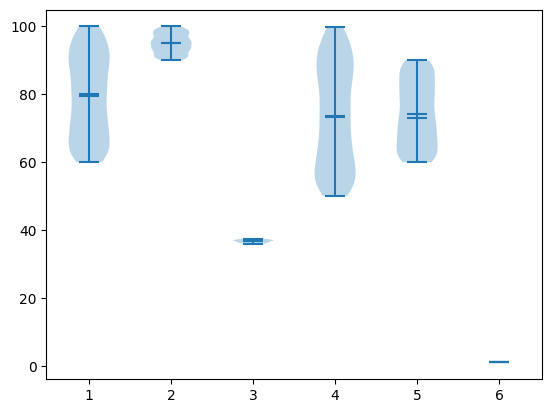

In [27]:
plt.violinplot(has_dem_stats, showmeans=True, showextrema=True, showmedians=True)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7e48211058d0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7e4821105840>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7e48211070a0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7e48211074f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7e4821107940>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7e4821107d90>}

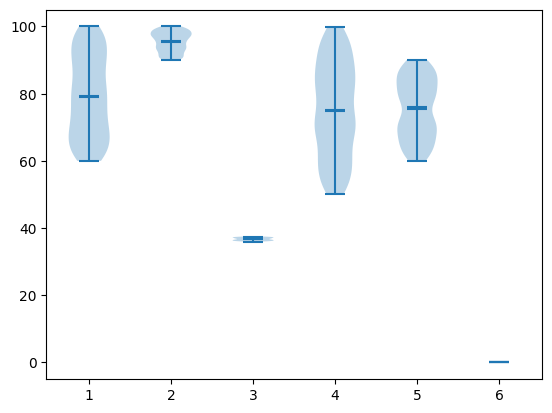

In [28]:
plt.violinplot(No_dem_stats, showmeans=True, showextrema=True, showmedians=True)

In [29]:
query = """
    SELECT
        Dementia,
        Gender,
        Age,
        Family_History,
        Physical_Activity,
        Smoking_Status
    FROM dementia_data
    SORT BY Dementia

"""



dementia_categ_stats = spark.sql(query)
dementia_categ_stats = dementia_categ_stats.toPandas()
dementia_categ_stats

,Dementia,Gender,Age,Family_History,Physical_Activity,Smoking_Status
0,0,Female,60,No,Sedentary,Current Smoker
1,0,Male,69,Yes,Moderate Activity,Former Smoker
2,0,Female,66,No,Mild Activity,Former Smoker
3,0,Female,66,No,Mild Activity,Former Smoker
4,0,Female,73,Yes,Mild Activity,Never Smoked
...,...,...,...,...,...,...
995,1,Female,76,No,Mild Activity,Never Smoked
996,1,Male,77,Yes,Mild Activity,Former Smoker
997,1,Female,83,Yes,Moderate Activity,Former Smoker
998,1,Male,88,Yes,Mild Activity,Never Smoked


In [30]:
dementia = dementia_categ_stats[dementia_categ_stats["Dementia"] == 1].sort_values("Gender")
dementia.head()

,Dementia,Gender,Age,Family_History,Physical_Activity,Smoking_Status
757,1,Female,69,Yes,Mild Activity,Never Smoked
702,1,Female,77,No,Mild Activity,Never Smoked
894,1,Female,85,Yes,Sedentary,Never Smoked
893,1,Female,85,No,Sedentary,Former Smoker
705,1,Female,73,No,Moderate Activity,Former Smoker


In [31]:
no_dementia = dementia_categ_stats[dementia_categ_stats["Dementia"] == 0].sort_values("Gender")
no_dementia.head()

,Dementia,Gender,Age,Family_History,Physical_Activity,Smoking_Status
0,0,Female,60,No,Sedentary,Current Smoker
285,0,Female,86,No,Sedentary,Never Smoked
282,0,Female,76,No,Moderate Activity,Former Smoker
280,0,Female,71,No,Moderate Activity,Never Smoked
276,0,Female,84,Yes,Sedentary,Current Smoker


In [32]:
dementia_df["Age"].min()

60

In [33]:
dementia_df["Age"].median()

75.0

In [34]:
# dementia status by family history
query = """
    SELECT
        Gender,
        COUNT(*) AS Gender_Count
    FROM dementia_data
    GROUP BY Gender
"""


gender_result = spark.sql(query)
gender_result = gender_result.toPandas()
gender_result

,Gender,Gender_Count
0,Female,504
1,Male,496


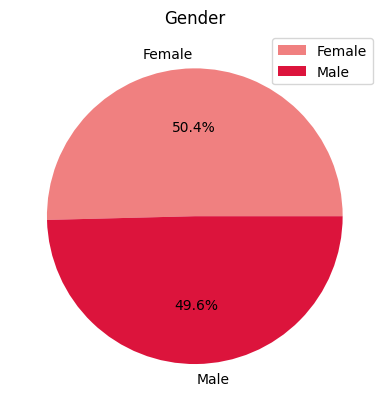

In [35]:
labels = gender_result["Gender"]
sizes = gender_result["Gender_Count"]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=["#F08080", "#DC143C"], autopct="%1.1f%%")
plt.title("Gender")
plt.legend()
plt.show()








In [36]:
# Read in data 2

df2 = pd.read_csv("/content/cleaned_dementia_with_rating_scales.csv")
df2.head(100)

,Unnamed: 0,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,0,0,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,1,0,457,0,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,2,1,0,0,75,12,2.0,23.0,0.5,1678.290000,0.736336,1.045710
3,3,1,560,0,76,12,2.0,28.0,0.5,1737.620000,0.713402,1.010000
4,4,1,1895,0,80,12,2.0,22.0,0.5,1697.911134,0.701236,1.033623
...,...,...,...,...,...,...,...,...,...,...,...,...
95,107,0,0,1,92,23,1.0,29.0,0.0,1454.280000,0.701155,1.206780
96,108,0,457,1,94,23,1.0,29.0,0.0,1474.350000,0.696004,1.190350
97,109,0,1526,1,97,23,1.0,30.0,0.0,1482.545247,0.689188,1.183775
98,110,0,0,0,74,18,2.0,29.0,0.0,1463.473210,0.736956,1.199202


In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  336 non-null    int64  
 1   Group       336 non-null    int64  
 2   MR Delay    336 non-null    int64  
 3   M/F         336 non-null    int64  
 4   Age         336 non-null    int64  
 5   EDUC        336 non-null    int64  
 6   SES         336 non-null    float64
 7   MMSE        336 non-null    float64
 8   CDR         336 non-null    float64
 9   eTIV        336 non-null    float64
 10  nWBV        336 non-null    float64
 11  ASF         336 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 31.6 KB


In [38]:
df2['M/F'] = df2['M/F'].apply(lambda x: 'male' if x == 1 else 'female')
df2.head(100)

,Unnamed: 0,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,0,female,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,1,0,457,female,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,2,1,0,female,75,12,2.0,23.0,0.5,1678.290000,0.736336,1.045710
3,3,1,560,female,76,12,2.0,28.0,0.5,1737.620000,0.713402,1.010000
4,4,1,1895,female,80,12,2.0,22.0,0.5,1697.911134,0.701236,1.033623
...,...,...,...,...,...,...,...,...,...,...,...,...
95,107,0,0,male,92,23,1.0,29.0,0.0,1454.280000,0.701155,1.206780
96,108,0,457,male,94,23,1.0,29.0,0.0,1474.350000,0.696004,1.190350
97,109,0,1526,male,97,23,1.0,30.0,0.0,1482.545247,0.689188,1.183775
98,110,0,0,female,74,18,2.0,29.0,0.0,1463.473210,0.736956,1.199202


In [39]:
df2.columns

Index(['Unnamed: 0', 'Group', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE',
       'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')

In [40]:
df2_valCount = df2['M/F'].value_counts()
type(df2_valCount)



pandas.core.series.Series

In [41]:
df2 = df2_valCount.to_frame(name="Gender_Count")
df2.head()

,Gender_Count
male,189
female,147


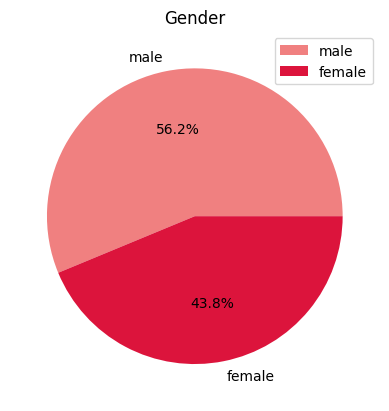

In [42]:
labels = df2.index
sizes = df2["Gender_Count"]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=["#F08080", "#DC143C"], autopct="%1.1f%%")
plt.title("Gender")
plt.legend()
plt.show()

In [43]:
# dementia status by has/does not have
query = """
    SELECT
        Dementia,
        COUNT(*) AS Dementia_Count
    FROM dementia_data
    GROUP BY Dementia
"""


gender_result = spark.sql(query)
gender_result = gender_result.toPandas()
gender_result

,Dementia,Dementia_Count
0,1,485
1,0,515


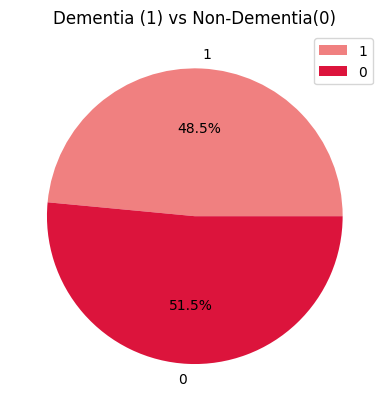

In [44]:
labels = gender_result["Dementia"]
sizes = gender_result["Dementia_Count"]

fig, ax = plt.subplots()
plt.pie(sizes, labels=labels, colors=["#F08080", "#DC143C"], autopct="%1.1f%%")
plt.title("Dementia (1) vs Non-Dementia(0)")
plt.legend()
plt.show()

In [46]:
# Read in data 2

df2 = pd.read_csv("/content/cleaned_dementia_with_rating_scales.csv")
df2.head(100)

,Unnamed: 0,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,0,0,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,1,0,457,0,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,2,1,0,0,75,12,2.0,23.0,0.5,1678.290000,0.736336,1.045710
3,3,1,560,0,76,12,2.0,28.0,0.5,1737.620000,0.713402,1.010000
4,4,1,1895,0,80,12,2.0,22.0,0.5,1697.911134,0.701236,1.033623
...,...,...,...,...,...,...,...,...,...,...,...,...
95,107,0,0,1,92,23,1.0,29.0,0.0,1454.280000,0.701155,1.206780
96,108,0,457,1,94,23,1.0,29.0,0.0,1474.350000,0.696004,1.190350
97,109,0,1526,1,97,23,1.0,30.0,0.0,1482.545247,0.689188,1.183775
98,110,0,0,0,74,18,2.0,29.0,0.0,1463.473210,0.736956,1.199202


In [47]:
df2['Group'] = df2['Group'].apply(lambda x: 'Demented' if x == 1 else 'Not Demented')
df2.head(100)

,Unnamed: 0,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,Not Demented,0,0,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,1,Not Demented,457,0,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,2,Demented,0,0,75,12,2.0,23.0,0.5,1678.290000,0.736336,1.045710
3,3,Demented,560,0,76,12,2.0,28.0,0.5,1737.620000,0.713402,1.010000
4,4,Demented,1895,0,80,12,2.0,22.0,0.5,1697.911134,0.701236,1.033623
...,...,...,...,...,...,...,...,...,...,...,...,...
95,107,Not Demented,0,1,92,23,1.0,29.0,0.0,1454.280000,0.701155,1.206780
96,108,Not Demented,457,1,94,23,1.0,29.0,0.0,1474.350000,0.696004,1.190350
97,109,Not Demented,1526,1,97,23,1.0,30.0,0.0,1482.545247,0.689188,1.183775
98,110,Not Demented,0,0,74,18,2.0,29.0,0.0,1463.473210,0.736956,1.199202


In [48]:
df2['Group'].value_counts()



Not Demented    190
Demented        146
Name: Group, dtype: int64

In [49]:
df2_Count = df2['Group'].value_counts()
type(df2_Count)

pandas.core.series.Series

In [50]:
df2 = df2_Count.to_frame(name="Count")
df2.head()

,Count
Not Demented,190
Demented,146


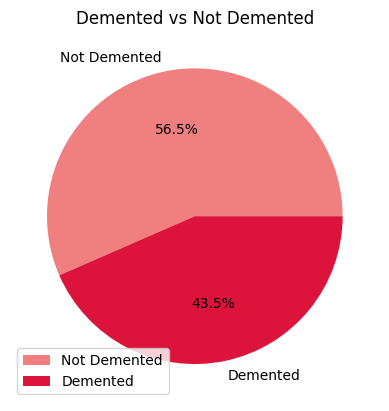

In [51]:
labels = df2.index
sizes = df2["Count"]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=["#F08080", "#DC143C"], autopct="%1.1f%%")
plt.title("Demented vs Not Demented")
plt.legend()
plt.show()

In [52]:
# dementia status by has/does not have
query = """
    SELECT
        Age,
        COUNT(*) AS Age_Count
    FROM dementia_data
    GROUP BY Age
    SORT BY Age
"""


gender_result = spark.sql(query)
gender_result = gender_result.toPandas()
gender_result

,Age,Age_Count
0,60,34
1,61,39
2,62,32
3,63,31
4,64,29
5,65,28
6,66,43
7,67,36
8,68,28
9,69,32


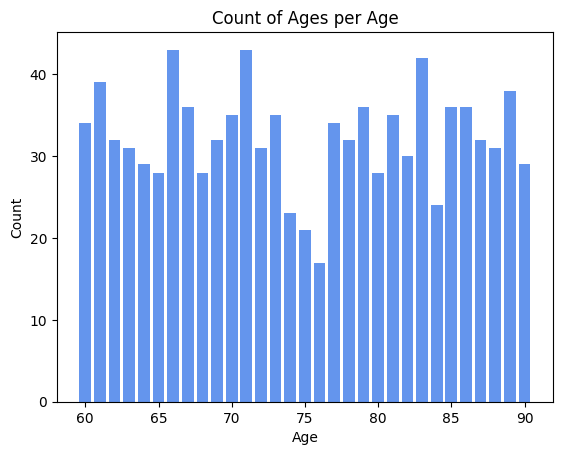

In [53]:
labels = gender_result["Age"].tolist()
sizes = gender_result["Age_Count"].tolist()
bar_colors = ['#6495ED']

fig, ax = plt.subplots()
ax.bar(labels, sizes, color=bar_colors[0])
ax.set_ylabel("Count")
ax.set_xlabel("Age")
ax.set_title("Count of Ages per Age")
plt.show()


In [55]:
# Read in data 2

df2 = pd.read_csv("/content/cleaned_dementia_with_rating_scales.csv")
df2.head(100)

,Unnamed: 0,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,0,0,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,1,0,457,0,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,2,1,0,0,75,12,2.0,23.0,0.5,1678.290000,0.736336,1.045710
3,3,1,560,0,76,12,2.0,28.0,0.5,1737.620000,0.713402,1.010000
4,4,1,1895,0,80,12,2.0,22.0,0.5,1697.911134,0.701236,1.033623
...,...,...,...,...,...,...,...,...,...,...,...,...
95,107,0,0,1,92,23,1.0,29.0,0.0,1454.280000,0.701155,1.206780
96,108,0,457,1,94,23,1.0,29.0,0.0,1474.350000,0.696004,1.190350
97,109,0,1526,1,97,23,1.0,30.0,0.0,1482.545247,0.689188,1.183775
98,110,0,0,0,74,18,2.0,29.0,0.0,1463.473210,0.736956,1.199202


In [56]:
df2['Age'].value_counts().sort_values()


98     1
94     1
96     1
95     1
97     1
60     2
93     3
64     3
92     3
87     3
91     3
63     3
62     4
67     4
61     4
90     5
65     5
89     6
86     8
85     8
88     8
79     9
84     9
66    10
83    11
72    11
74    11
70    12
69    12
68    13
81    15
77    15
76    16
82    16
71    16
80    19
78    20
75    20
73    24
Name: Age, dtype: int64

In [57]:
df2_age = df2['Age'].value_counts()
type(df2_age)

pandas.core.series.Series

In [58]:
df2 = df2_age.to_frame(name="Count")
df2.head()

,Count
73,24
75,20
78,20
80,19
71,16


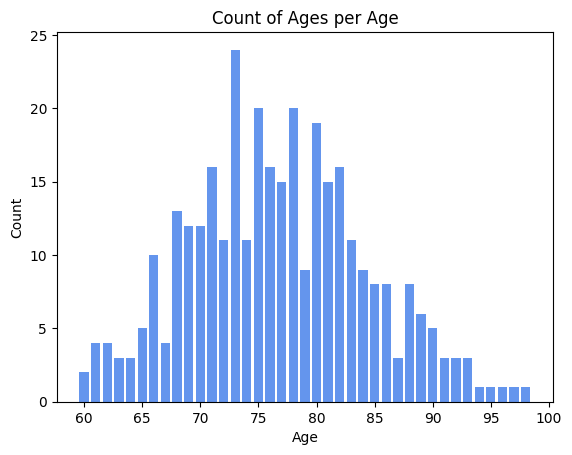

In [59]:
labels = df2.index
sizes = df2["Count"].tolist()
bar_colors = ['#6495ED']

fig, ax = plt.subplots()
ax.bar(labels, sizes, color=bar_colors[0])
ax.set_ylabel("Count")
ax.set_xlabel("Age")
ax.set_title("Count of Ages per Age")
plt.show()
